In [1]:
import os
import subprocess

tmpdir = '/content/tmp/' #temporal location to download and store the dataset

out=subprocess.call(["mkdir",tmpdir]) #create a empty directory
os.chdir(tmpdir) #move to directory

!wget http://www-vpu.eps.uam.es/~jcs/pub/utils.zip -O utils.zip #download utils
!unzip -o -q utils.zip -d . #unzip file

#install software requirements (pytorch, pillow, google-drive-ocamlfuse)
#!pip uninstall -y torch #remove any previous version
!pip install -r ./utils/requirements_cuda.txt

--2020-03-28 21:09:46--  http://www-vpu.eps.uam.es/~jcs/pub/utils.zip
Resolving www-vpu.eps.uam.es (www-vpu.eps.uam.es)... 150.244.57.170
Connecting to www-vpu.eps.uam.es (www-vpu.eps.uam.es)|150.244.57.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2411 (2.4K) [application/zip]
Saving to: ‘utils.zip’

utils.zip           100%[===================>]   2.35K  --.-KB/s    in 0s      

2020-03-28 21:09:46 (348 MB/s) - ‘utils.zip’ saved [2411/2411]

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 496.9MB 5.2MB/s 
     |████████████████████████████████| 5.9MB 3.7MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torc


A lo largo del código utilizaremos una condición para indicar si se realiza el cálculo con GPU o CPU

In [2]:
import torch 

#flag to indicate that we want to use CUDA
use_cuda = True 

#check condition
if use_cuda and torch.cuda.is_available():
  print "GPU enabled"
else:
  print "CPU enabled"
  
  

GPU enabled


### Rutas de trabajo
En este script, se utilizarán las siguientes rutas

In [0]:
tmpdir = '/content/tmp/' #temporal location to download and store the dataset

drivedir = '/content/gdrive'
pracdir = drivedir + '/My Drive/p1indexacion' #directory for practica 1 indexacion
datadir = pracdir + '/data' #directory for storing datasets
resudir = pracdir + '/result' #directory to save results

### Google Drive

Ejecute el siguiente código para enlazar este script con su cuenta de Google Drive. Los datos que se generen aquí se guardarán en su carpeta Drive para posterior uso. Por defecto, la unidad de Google Drive es enlaza con el directorio **/content/gdrive/**.

In [4]:
from google.colab import drive
drive.mount(drivedir)

print 'Google Drive mount completed'

#check correct mount of drive directory
!df -h

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Google Drive mount completed
Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   33G   33G  50% /
tmpfs            64M     0   64M   0% /dev
tmpfs            13G     0   13G   0% /sys/fs/cgroup
tmpfs            13G   16K   13G   1% /var/colab
/dev/sda1        75G   37G   38G  50% /opt/bin
shm              13G  4.0K   13G   1% /dev/shm
tmpfs            13G     0   13G   0% /proc/acpi
tmpfs            13G     0   13G   0% /proc/scsi
tmpfs   

## Dataset

En este ejemplo de entrenamiento, vamos a utilizar el dataset Scenes15

In [5]:
import subprocess
import os

out=subprocess.call(["mkdir",pracdir])#create directory
out=subprocess.call(["mkdir",datadir])#create directory
out=subprocess.call(["mkdir",resudir])#create directory

os.chdir(datadir) #move to directory

#download and unzip the file
!wget http://www-vpu.eps.uam.es/~jcs/pub/Scene15.zip -O Scene15.zip
!unzip -o -q Scene15.zip -d .

print 'Dataset downloaded and unzipped'

!ls -lah #show directory & file usage

--2020-03-28 21:13:22--  http://www-vpu.eps.uam.es/~jcs/pub/Scene15.zip
Resolving www-vpu.eps.uam.es (www-vpu.eps.uam.es)... 150.244.57.170
Connecting to www-vpu.eps.uam.es (www-vpu.eps.uam.es)|150.244.57.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86395596 (82M) [application/zip]
Saving to: ‘Scene15.zip’

Scene15.zip         100%[===================>]  82.39M  21.6MB/s    in 9.0s    

2020-03-28 21:13:31 (9.17 MB/s) - ‘Scene15.zip’ saved [86395596/86395596]

Dataset downloaded and unzipped
total 83M
drwx------ 4 root root 4.0K Feb 13 20:29 Scene15
-rw------- 1 root root  83M Feb 28  2018 Scene15.zip


Parametros para la generación del dataset

In [0]:
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms


#path to the downloaded dataset
dataset_dir = datadir + '/Scene15/'


#number of samples/images per group
batch_size=8

input_size=256

#data transformation
rf=256
Resizing_factor = (rf,rf)

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                normalize                              
                               ])


#list & load images
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_dir, x), transform) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#load & convert images to tensors in Python
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}


## Creación de la red

A continuación, creamos una red tipo Lenet (modificada para soportar imágenes distintas a 32x32)

In [0]:
#Lenet network
#https://github.com/kuangliu/pytorch-cifar/tree/master/models

#Extensions
#https://discuss.pytorch.org/t/inferring-shape-via-flatten-operator/138/3
#https://stackoverflow.com/questions/42479902/how-view-method-works-for-tensor-in-torch

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Net(nn.Module):
  
    #define the structure of the network
    def __init__(self, input_shape=(3, 224, 224),num_outputs=15):
        super(Net, self).__init__()
        # Convolutional layer - 3 input image channel, 6 output channels, 5x5 square convolution 
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=64, kernel_size=7, stride=1, padding=0)
        
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(kernel_size=16, stride=2, padding=0)
        
        # Convolutional layer - 6 input data channel, 16 output channels, 5x5 square convolution 
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1) 

        # Max pooling over a (2, 2) window
        self.pool2 = nn.MaxPool2d(kernel_size=16, stride=2, padding=0)    

        # Convolutional layer - 6 input data channel, 16 output channels, 5x5 square convolution 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3)   

        # Max pooling over a (2, 2) window
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)    

        # Convolutional layer - 6 input data channel, 16 output channels, 5x5 square convolution 
        self.conv4 = nn.Conv2d(in_channels=192, out_channels=250, kernel_size=5)

        n_size = self._get_conv_output(input_shape)
        
        # Fully connected neural network layers       
        self.fc1 = nn.Linear(in_features=n_size, out_features=120)
        self.fc2 = nn.Linear(in_features=120,    out_features=84)
        self.fc3 = nn.Linear(in_features=84,     out_features=num_outputs)

    #define how data flows through the network
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        
        #The view function is meant to reshape the tensor (flatten operator).
        x = x.view( x.size(0),-1)
                
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
        
    def _get_conv_output(self, shape):
        bs = 1
        x = Variable(torch.rand(bs, *shape))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        output_feat = self.pool(F.relu(self.conv4(x)))
               
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

In [8]:
import os
os.chdir(tmpdir) #move to directory

#runs script and keeps variables
#%run -i ./utils/mylenet.py

# get some random training images to initialize network
images, labels = iter(dataloaders['train']).next()

net = Net(images[0].size(), num_outputs=len(class_names)) 
print(net)
print "Network ready!"


Net(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(16, 16), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(16, 16), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (conv3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (conv4): Conv2d(192, 250, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=250, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=15, bias=True)
)
Network ready!


In [9]:
if use_cuda and torch.cuda.is_available():
  net.cuda()
  
print "Network ready to train using CUDA!"

Network ready to train using CUDA!


## Definir una función de coste/optimizador

En este ejemplo utilizamos Cross-Entropy para medir la precisión de nuestro clasificador y SGD como optimizador.

In [0]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR
import math


end_lr = 0.001
start_lr = 1
lr_epochs = 100

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=end_lr, momentum=0.9)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

## Entrenar la red

Ejecución iterativa sobre los datos de entrenamiento/test y actualización de los pesos

In [11]:
import time
import numpy as np
from torch.autograd import Variable

display_batch_iter = 100
number_epochs = 30


epoch_loss =  np.zeros((number_epochs,1))
epoch_train_acc =  np.zeros((number_epochs,1))
epoch_test_acc =  np.zeros((number_epochs,1))  
train_time =  0.0

Ntrain = len(image_datasets['train']) #number of samples for training
Ntest = len(image_datasets['val']) #number of samples for test/validation
    
start = time.time()

if use_cuda and torch.cuda.is_available():
  print('Training in GPUmode #epochs=%d #batches=%d batchsize=%d' % (number_epochs, len(dataloaders['train']),batch_size))
else:
  print('Training in CPUmode #epochs=%d #batches=%d batchsize=%d' % (number_epochs, len(dataloaders['train']),batch_size))

print('**** Printing loss every %5d batches ****' % (display_batch_iter))  
for epoch in range(number_epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    if(epoch+1) % 45 == 0:
      # Decay Learning Rate
      scheduler.step()
      # Print Learning Rate
      print('Epoch:', epoch,'LR:', scheduler.get_lr())
    for i, data in enumerate(dataloaders['train'], 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        if use_cuda and torch.cuda.is_available():
          inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
          inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        epoch_loss[epoch] += loss.data[0]
        if i % display_batch_iter == display_batch_iter-1:    # print every XXX mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / display_batch_iter))
            running_loss = 0.0

    # compute accuracy on training set
    correct1 = 0.0
    for data in dataloaders['train']:    
      images, labels = data
      if use_cuda and torch.cuda.is_available():
        outputs = net(Variable(images.cuda()))
      else:
        outputs = net(Variable(images))
      _, predicted = torch.max(outputs.data, 1)
      if use_cuda and torch.cuda.is_available():
        correct1 += (predicted == labels.cuda()).sum()
      else:
        correct1 += (predicted == labels).sum()      
      
    # compute accuracy on test set
    correct2 = 0.0
    for data in dataloaders['val']:    
      images, labels = data
      if use_cuda and torch.cuda.is_available():
        outputs = net(Variable(images.cuda()))
      else:
        outputs = net(Variable(images))
      _, predicted = torch.max(outputs.data, 1)
      if use_cuda and torch.cuda.is_available():
        correct2 += (predicted == labels.cuda()).sum()
      else:
        correct2 += (predicted == labels).sum()
    
    epoch_loss[epoch] = epoch_loss[epoch] / len(dataloaders['train']) # average loss for each epoch
    epoch_train_acc[epoch] =  100 * correct1 / Ntrain   # average train accuracy for each epoch
    epoch_test_acc[epoch]  =  100 * correct2 / Ntest    # average test accuracy for each epoch
    print('Epoch %02d, loss: %1.3f, accuracy train: %2.3f %% (correct %04d total %04d ) accuracy test: %2.3f %% (correct %04d total %04d )' % (epoch + 1, epoch_loss[epoch], epoch_train_acc[epoch], correct1, Ntrain, epoch_test_acc[epoch], correct2, Ntest ))
    
train_time = time.time() - start
print('Finished Training (' + str(train_time) + ' secs)')

Training in GPUmode #epochs=30 #batches=188 batchsize=8
**** Printing loss every   100 batches ****
[1,   100] loss: 2.710
Epoch 01, loss: 2.710, accuracy train: 6.667 % (correct 0100 total 1500 ) accuracy test: 10.279 % (correct 0310 total 3016 )
[2,   100] loss: 2.706
Epoch 02, loss: 2.709, accuracy train: 6.667 % (correct 0100 total 1500 ) accuracy test: 10.279 % (correct 0310 total 3016 )
[3,   100] loss: 2.705
Epoch 03, loss: 2.707, accuracy train: 6.667 % (correct 0100 total 1500 ) accuracy test: 10.279 % (correct 0310 total 3016 )
[4,   100] loss: 2.707
Epoch 04, loss: 2.706, accuracy train: 9.800 % (correct 0147 total 1500 ) accuracy test: 12.997 % (correct 0392 total 3016 )
[5,   100] loss: 2.705
Epoch 05, loss: 2.704, accuracy train: 11.067 % (correct 0166 total 1500 ) accuracy test: 14.290 % (correct 0431 total 3016 )
[6,   100] loss: 2.701
Epoch 06, loss: 2.701, accuracy train: 11.667 % (correct 0175 total 1500 ) accuracy test: 14.290 % (correct 0431 total 3016 )
[7,   100]

Finalmente podemos guardar los datos tras el entrenamiento

In [12]:
#save results in a single file
import pickle
import os
import subprocess

out=subprocess.call(["mkdir",resudir])#create directory
os.chdir(resudir) #move to drive directory

# Saving the objects:
f = open('training_baseline_cuda_results_epochs_' + 'mylenet_4_layers' + '.pkl', 'wb')
pickle.dump([epoch_train_acc, epoch_test_acc, epoch_loss, train_time, number_epochs, batch_size], f)
f.close()
print('Saved data')

Saved data


Posteriormente, si quisieramos recuperar las variables/objetos para analizar, utilizaremos el siguiente código

In [0]:
#get results from a single file
import pickle
import os
os.chdir(resudir) #move to drive directory

# Load the objects
f = open('training_baseline_cuda_results_epochs_mylenet_4_layers.pkl', 'rb')
epoch_train_acc, epoch_test_acc, epoch_loss, train_time, number_epochs, batch_size = pickle.load(f)

## Resultados tras entrenamiento 



### Análisis de precisión y función de pérdidas
A continuación pintamos las variables que hemos acumulado durante el entrenamiento.

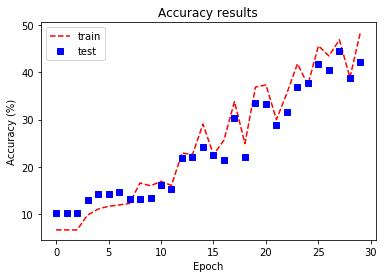

In [14]:
import matplotlib.pyplot as plt

t = range(number_epochs)
lineObjects =plt.plot(t,epoch_train_acc,'r--',t,epoch_test_acc,'bs')
plt.legend(lineObjects, ('train', 'test'))
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Accuracy results')

import os
os.chdir(resudir) #move to drive directory for saving data

plt.savefig('training_accuracy_baseline__epochs_'+ 'mylenet_4_layers' '_GPU.png',bbox_inches='tight')#call this function before "plt.show()"
plt.show()

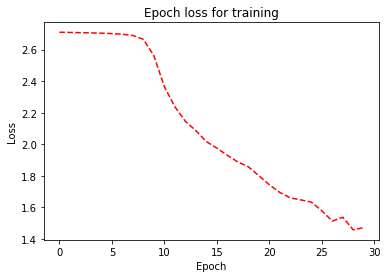

In [15]:
import matplotlib.pyplot as plt

import os
os.chdir(resudir) #move to drive directory for saving data

t = range(number_epochs)
plt.plot(t,epoch_loss,'r--')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Epoch loss for training') 
plt.show()

### Ejemplos de resultado

Es recomendable repasar los resultados obtenidos tanto gráficamente como estadísticamente.

Primero, seleccionamos algunos datos y visualmente verificamos errores:


('GroundTruth: ', 'Coast Coast LivingRoom Industrial InsideCity Coast Street TallBuilding')
('Predicted: ', 'Coast Coast Bedroom Industrial Store Coast Street Industrial')


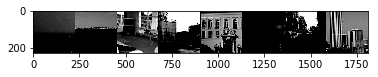

In [16]:
import torchvision

# function to show an image
def imshow(img):
    #img = img / 2 + 0.5  # unnormalize if normalization is done in transform
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
#get sample data
images, labels = iter(dataloaders['val']).next()
   
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(batch_size)))

outputs = net(Variable(images.cuda()))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]] for j in range(batch_size)))

Posteriormente estudiamos los resultados para cada clase

In [17]:
class_correct = list(0. for i in range(len(class_names)))
class_total = list(0. for i in range(len(class_names)))
for data in dataloaders['val']:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels.cuda()).squeeze()
    for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

class_totalT = 0
for i in range(len(class_names)):
    print('Accuracy of %5s : %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))
    class_totalT += class_total[i]
print('Total test data = %d images' % (class_totalT))

Accuracy of Bedroom : 41 %
Accuracy of Coast : 50 %
Accuracy of Forest : 53 %
Accuracy of Highway : 67 %
Accuracy of Industrial : 28 %
Accuracy of InsideCity : 32 %
Accuracy of Kitchen : 13 %
Accuracy of LivingRoom : 12 %
Accuracy of Mountain : 18 %
Accuracy of Office : 68 %
Accuracy of OpenCountry : 42 %
Accuracy of Store : 55 %
Accuracy of Street : 46 %
Accuracy of Suburb : 68 %
Accuracy of TallBuilding : 46 %
Total test data = 3016 images
